# Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# importing modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import pandas as pd
import os
from dotenv import load_dotenv

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load_dotenv()

# secure_bundle = os.getenv('secure_bundle')
# client_id = os.getenv('client_id')
# client_secret = os.getenv('client_secret')

# cloud_config= {
#         'secure_connect_bundle': secure_bundle  
# }

# auth_provider = PlainTextAuthProvider(client_id, client_secret)
# cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
# session = cluster.connect()

# train_df = pd.DataFrame(list(session.execute('SELECT * FROM flight_fare.data_train;')))

# train_df.drop(columns=["Key"],inplace=True)

In [3]:
train_df = pd.read_csv(r"D:\GitHub_Projects\Internship\ineuron\artifacts\data_train.csv")
train_df.drop(columns=["Key"],inplace=True)

#### Show Top 5 records

In [4]:
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24-03-2019,Banglore,New Delhi,BLR ? DEL,22:20,22-03-2023 01:10,2h 50m,non-stop,No info,3897
1,Air India,01-05-2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09-06-2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,10-06-2023 04:25,19h,2 stops,No info,13882
3,IndiGo,12-05-2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01-03-2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
train_df.shape

(10683, 11)

In [6]:
def drop_na(df):
    train_df.dropna(inplace=True)
    
drop_na(train_df)    
train_df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

#### Changing datatype of Date_of_Journey, Dep_Time, Arrival_Time columns to datetime

In [7]:
train_df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [8]:
def jouney_tranformation(df):
    df['journey_day'] = pd.to_datetime(df["Date_of_Journey"]).dt.day
    df['journey_month']= pd.to_datetime(df["Date_of_Journey"]).dt.month
    df.drop('Date_of_Journey', axis=1, inplace=True)

def arival_time_tranformation(df):
    df["Arrival_Time_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
    df["Arrival_Time_min"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
    df.drop("Arrival_Time",axis=1,inplace=True)

def dep_time_transformation(df):
    df["Dep_Time_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
    df["Dep_Time_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute
    df.drop("Dep_Time",axis=1,inplace=True)

In [9]:
def duration_tranformation(df):
    def dur_hour(x):
        return x.split(" ")[0][0:-1]

    def dur_minutes(x):
        return x.split(" ")[1][0:-1]

    duration = list(df['Duration'])
    for i in range(len(duration)):
        if len(duration[i].split(" "))==2:
            pass
        else:
            if "h" in duration[i]:
                duration[i] = duration[i]+" 0m"
            else:
                duration[i] = "0h "+duration[i] 
    df['Duration'] = duration

    # Extracting Duration Hours
    df["Dur_hours"] = df["Duration"].apply(dur_hour).astype(int)
    # Extracting Duration Minutes
    df["Dur_mins"] = df["Duration"].apply(dur_minutes).astype(int)
    # Dropping Duration column
    df.drop(columns=["Duration"],inplace=True)


In [10]:
def replace_vlaues(df):
    df.Airline.replace("Trujet","other",inplace=True)
    df.Airline.replace("Vistara Premium economy","other",inplace=True)
    df.Airline.replace("Jet Airways Business","other",inplace=True)
    df.Airline.replace("Multiple carriers Premium economy","other",inplace=True)
    df.Total_Stops.replace("4 stops","3 stops",inplace=True)

In [11]:
def drop_features(df):
    df.drop(columns=["Additional_Info","Route"],inplace=True)

In [12]:
jouney_tranformation(train_df)
arival_time_tranformation(train_df)
dep_time_transformation(train_df)
duration_tranformation(train_df)
replace_vlaues(train_df)
drop_features(train_df)

In [13]:
train_df.dtypes

Airline              object
Source               object
Destination          object
Total_Stops          object
Price                 int64
journey_day           int64
journey_month         int64
Arrival_Time_hour     int64
Arrival_Time_min      int64
Dep_Time_hour         int64
Dep_Time_min          int64
Dur_hours             int32
Dur_mins              int32
dtype: object

#### Preparing X and Y variables

In [14]:
X = train_df.drop(columns=['Price'],axis=1)

In [15]:
X.head()

,Airline,Source,Destination,Total_Stops,journey_day,journey_month,Arrival_Time_hour,Arrival_Time_min,Dep_Time_hour,Dep_Time_min,Dur_hours,Dur_mins
0,IndiGo,Banglore,New Delhi,non-stop,24,3,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,2 stops,5,1,13,15,5,50,7,25
2,Jet Airways,Delhi,Cochin,2 stops,6,9,4,25,9,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,5,12,23,30,18,5,5,25
4,IndiGo,Banglore,New Delhi,1 stop,3,1,21,35,16,50,4,45


In [16]:
y = train_df['Price']
y

0         3897
1         7662
2        13882
3         6218
4        13302
         ...  
10678     4107
10679     4145
10680     7229
10681    12648
10682    11753
Name: Price, Length: 10682, dtype: int64

## Data Tranformation

In [17]:
X.Total_Stops.isna().value_counts()

False    10682
Name: Total_Stops, dtype: int64

In [18]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features)       
    ]
)

In [19]:
X = preprocessor.fit_transform(X)

In [20]:
X.shape

(10682, 32)

#### Create an Evaluate Function to give all metrics after model Training

In [21]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((8545, 32), (2137, 32))

In [22]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "SVR": SVR(kernel="linear"),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 2981.8635
- Mean Absolute Error: 2006.7360
- R2 Score: 0.5804
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2957.0214
- Mean Absolute Error: 2017.2387
- R2 Score: 0.5945


Lasso
Model performance for Training set
- Root Mean Squared Error: 2981.6933
- Mean Absolute Error: 2002.7335
- R2 Score: 0.5804
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2958.6156
- Mean Absolute Error: 2013.3540
- R2 Score: 0.5940


Ridge
Model performance for Training set
- Root Mean Squared Error: 2981.6697
- Mean Absolute Error: 2003.3925
- R2 Score: 0.5804
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2958.4127
- Mean Absolute Error: 2014.3303
- R2 Score: 0.5941


SVR
Model performance for Training set
- Root Mean Squared Error: 3563.8415
- Mean Absolute Error: 2265.3386
- R2 Score: 0.4006

### Results

In [24]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
8,CatBoosting Regressor,0.859350
7,XGBRegressor,0.827610
6,Random Forest Regressor,0.788729
4,K-Neighbors Regressor,0.745147
5,Decision Tree,0.712957
0,Linear Regression,0.594474
2,Ridge,0.594092
1,Lasso,0.594037
3,SVR,0.402636
9,AdaBoost Regressor,0.345193


In [25]:
catb_model = CatBoostRegressor(verbose=False)
catb_model = catb_model.fit(X_train, y_train)
y_pred = catb_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 85.94


## Plot y_pred and y_test

<AxesSubplot: xlabel='Price'>

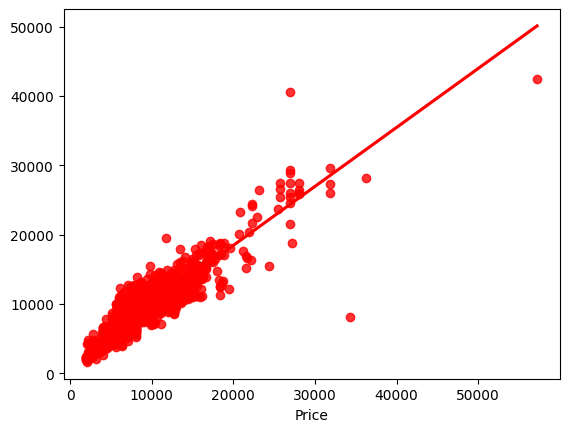

In [26]:
sns.regplot(x=y_test,y= y_pred ,ci=None,color ='red')

In [27]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
6075,16655,17216.498195,-561.498195
3544,4959,6267.958192,-1308.958192
9291,9187,8431.726722,755.273278
5032,3858,4026.612997,-168.612997
2483,12898,13891.400092,-993.400092
...,...,...,...
9797,7408,10475.912120,-3067.912120
9871,4622,5156.648940,-534.648940
10063,7452,6561.522206,890.477794
8802,8824,12102.471576,-3278.471576
